# Hypothesis Testing

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

sns.set()  # This helps make our plots look nicer

# These make our figures bigger
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.dpi'] = 100

*You may find it helpful to review [Chapter 11](https://inferentialthinking.com/chapters/11/Testing_Hypotheses.html) and [Chapter 12](https://inferentialthinking.com/chapters/12/Comparing_Two_Samples.html) of the Data 8 textbook, which cover the basics of hypothesis testing.*

Hypothesis testing is a specific kind of binary decision-making problem. Although the **null hypothesis statistical test (NHST)** framework has been criticized in recent years, it still provides a useful framework for making decisions from data. We'll explore these criticisms later, but to start, here's a quick refresher on how the process works:

1. Determine the viewpoint that you want to test, and decide on:
   * Null hypothesis: a chance model under which you can either simulate data or analytically compute the distribution of data
   * Alternative hypothesis: viewpoint from the question
   * Test statistic: quantity computed from your data to help you decide between the two hypotheses (in this book, we'll always use the convention that larger values of the test statistic should favor the alternative hypothesis, without loss of generality).
2. Compute the value of the test statistic on your data.
3. Compute the distribution of the test statistic under the null distribution, either by simulation or analytically.
4. Compute a p-value: this is the probability, if the null hypothesis is true, of obtaining a test statistic that is equal to or larger than the observed value.
5. Compare that p-value to some threshold: if the p-value is smaller than the threshold, our test statistic was very unlikely under the null, so our data support the alternative hypothesis. If the p-value is larger, then the data support the null hypothesis.

In [ ]:
# NO CODE

# VIDEO: B-H Algorithm Overview and Example
from IPython.display import YouTubeVideo
YouTubeVideo('g8NepbdUOBU')

## Hypothesis testing and binary decision-making

We'll frame hypothesis testing as a binary decision-making problem, where we decide between the null and alternative hypotheses, and we assume that one of them is true (note that this framing is flawed; see below for more). In this case, **reality** corresponds to which hypothesis is actually true, and we make our **decision** based on the p-values. 

In order to translate the p-values into binary decisions, we'll have to decide on some threshold(s) for doing so: we'll spend the rest of this chapter analyzing different ways to pick this threshold (or thresholds), and what assumptions are encoded in each one.

Here are some important notes about conventions and vocabulary:
* By convention, we'll always define the null hypothesis as 0, and the alternative hypothesis as 1.
* We'll use the following terms interchangeably (in other words, they all mean the same thing):
  * "reject the null hypothesis"
  * "make a discovery"
  * "make a decision of 1" ($D = 1$)
  
### Limitations of binary outlook on hypothesis testing

In many cases, the null and alternative hypotheses are not necessarily mutually exclusive! When we make a discovery, or equivalently, reject the null hypothesis, this only means that **the data we observed are unlikely if the null hypothesis is true**. In many cases, this doesn't necessarily mean that the alternative hypothesis is true! A rejection of the null hypothesis is often only one step toward showing an alternative hypothesis that we're interested in. 

For example, consider a blood pressure drug trial, where researchers want to show that the drug lowers blood pressure. They conduct a randomized experiment to measure the drug's effects. They precisely state their null hypothesis, that the drug has no effect on blood pressure, as "there is no difference in the distribution of blood pressure changes between the population of people who take the drug and the population of people who don't". Since they're interested in showing a decrease (rather than just a change), they state their alternative hypothesis, that the drug lowers blood pressure, as "the distribution of blood pressure changes in people who take the drug  is lower than the distribution for people who don't". 

In general, in this situation, consider the following four statements:

1. The null hypothesis: *the outcomes for treatment/control follow the same distribution*
2. The logical complement of the null hypothesis: *the outcomes for treatment/control do **not** follow the same distribution* (direct logical inversion of the null hypothesis)
3. The alternative hypothesis: *the outcomes if treated follow a lower-mean distribution than the outcomes if untreated*
4. What the researchers actually want to show: *the drug lowers blood pressure in a clinically meaningful and beneficial way*

Let's visualize the space of possible outcomes to help us understand the relationship between these four statements:

![nhst_outcomes_diagram.png](nhst_outcomes_diagram.png)

Consider the case where we reject the null hypothesis. Without knowing any other information, if we want to make a binary decision, we can only decide that statement 2 is true (i.e., that the truth lies somewhere in the entire blue-colored region on the right side). But in practice, we want to make a binary decision between statements 1 (orange-colored left side) and 4 (smallest dark blue oval): in other words, we want to show that either there is no effect, or there is a meaningful effect in the direction that we're interested in. In order to do this, we must rule out all the other possibilities. 

We can rule out some of these possibilities through smart statistical choices. For example, the researchers decided on a one-tailed test (i.e., using the alternative hypothesis "the outcome is lower") rather than a two-tailed test (i.e., using the alternative hypothesis "the outcome is different"), and chose a test statistic that reflects that (e.g., difference between treatment/control means, rather than absolute difference). This ensures that our binary decision is between statement 1, the null hypothesis (orange area on the left), and statement 3, the alternative hypothesis they chose (larger blue ellipse on the right).

In order for our binary decision to be meaningful, we need to eliminate possibilities outside statement 4 (the small blue oval). In order to do this, we must ensure **good experimental design** and **good statistical practices**. This includes avoiding confounding variables, ensuring that our effect sizes are meaningful in the real world, avoiding practices such as p-hacking and multiple testing (see the next section for more on these), and so on.

*Exercise*: For each of the possible outcomes below, determine where they fall on the diagram above.
1. The drug consistently lowers blood pressure, but by an amount that is medically insignificant (i.e., the decrease has no meaningful impact on any other biological processes in the body, or any other clinical outcomes).
2. The drug raises blood pressure.
3. The drug lowers blood pressure by an amount that is potentially dangerous in certain individuals.
4. The drug was originally designed to lower cholesterol, but after expensive and unsuccessful trials on cholesterol, the pharmaceutical company's researchers decided to look at ten other factors, and found that blood pressure happened to be lower in the treatment group. However, this finding was due to chance.

From these examples, we can see that conducting a hypothesis test is not a decisive statement: instead, it should be viewed as one step within a larger process.

### Connecting $p$-values with false positive rate

*You may find it helpful to review [Chapter 15](http://prob140.org/textbook/content/Chapter_15/01_Density_and_CDF.html) of the Data 140 textbook, which covers continuous random variables.*

We'll work through a few exercises to help us understand the connection between $p$-values and the error rates described in the previous section. In the process, we'll get some practice reasoning about probabilities, and learn some important facts about the distribution of $p$-values under the null hypothesis.



**Exercise 1**: Suppose the null hypothesis is true. In this case, what is the probability of obtaining a $p$-value less than 0.05?

**Solution**: In order to answer this question, we'll look at the distribution of the test statistic under the null hypothesis, and use what we know about probabilities. If the null hypothesis is true, then the test statistic comes from some distribution that we can either simulate or analytically compute. We'll represent it visually as follows. Note that everything we're about to conclude is true even if the shape of the distribution is very different: we're only making it to facilitate easy visualization.

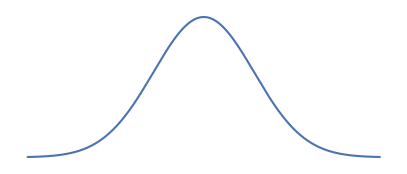

In [13]:
f, ax = plt.subplots(1, 1, figsize=(5, 2))
x = np.linspace(-3.5, 3.5, 1000)
y = stats.norm.pdf(x)
ax.axis([-3.5, 3.5, -0.05, 0.41])
ax.axis('off')
ax.plot(x, y);

What does it mean to obtain a $p$-value less than 0.05? This happens when our test statistic is large enough that it's unlikely according to the null distribution. Specifically, let's choose a particular value of the test statistic $a$, chosen such that the area under the curve to the right of $a$ is 0.05:

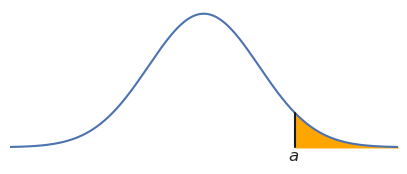

In [53]:
f, ax = plt.subplots(1, 1, figsize=(5, 2))
x = np.linspace(-3.5, 3.5, 1000)
y = stats.norm.pdf(x)

a = stats.norm.isf(0.05)

ax.plot(x, y);
ax.plot([a, a], [0, stats.norm.pdf(a)], 'k')
x_gt_a = x[x > a]
ax.fill_between(x_gt_a, 0, stats.norm.pdf(x_gt_a), color='orange');
ax.annotate('$a$', [a - 0.12, -0.04])
ax.axis([-3.5, 3.5, -0.05, 0.41])
ax.axis('off');


If our test statistic is $a$, then the $p$-value is the probability of getting a value greater than or equal to $a$. That probability is the area under the curve to the right of $a$. By construction, that area is 0.05 (in other words, we set things up and chose $a$ to have an area of 0.05).

So, a test statistic of $a$ results in a $p$-value of 0.05. We also know that any test statistic greater than $a$ will result in a $p$-value less than 0.05 (since there will be less area). Putting it all together, we can conclude that any test statistic greater than or equal to $a$ will result in a $p$-value less than or equal to 0.05.

Now, what is the probability of obtaining a test statistic greater than or equal to $a$, if the null hypothesis is true? The answer is just the area under the null distribution to the right of $a$. By construction, this area is $0.05$. So, the probability of obtaining a $p$-value less than or equal to 0.05 is simply 0.05!

To summarize what we did:
1. Chose a test statistic value $a$ such that the area under the the null distribution to the right of $a$ is 0.05
2. Determined that "obtaining a $p$-value less than or equal to 0.05" is exactly equivalent to "obtaining a test statistic greater than or equal to $a$"
3. Computed that if the null is true, the probability of "obtaining a test statistic greater than or equal to $a$" is 0.05
4. Found (by combining 2 and 3) that if the null is true, the probability of "obtaining a $p$-value less than or equal to 0.05 is 0.05.


**Exercise 3**: Suppose the null hypothesis is true. In this case, what is the probability of obtaining a $p$-value less than $\gamma$ (assuming $0 < \gamma \leq 1$)? *Note this is a generalization of the previous question, using $\gamma$ instead of the specific value $0.05$.*

**Solution**: Throughout our solution to the last exercise, there was nothing special about the value of 0.05 that we used. All of our conclusions are still valid even if we choose any other threshold between 0 and 1. So, we can safely conclude that this probability is $\gamma$.

**Exercise 4**: Suppose our $p$-value threshold is $\gamma$. What is the false positive rate for this test?

**Solution**: We know the following things:
* The false positive rate is $P(D=1 | R=0)$. 
* In hypothesis testing, this is the probability of rejecting the null hypothesis given that the null hypothesis is true. 
* We reject the null hypothesis whenever our $p$-value is below the threshold.
* From the last exercise: if the null is true, then the probability of obtaining a $p$-value less than or equal to $\gamma$ is $\gamma$.

Putting these facts together, the false positive rate is $\gamma$: in other words, **the p-value threshold that we use for a test is the false positive rate for that test**.

**Exercise 5**: If the null hypothesis is true, what is the distribution of the $p$-value? *Hint: the answer is a well-known distribution.*

**Solution**: Let $p$ be the $p$-value (this is a random variable).

In Exercise 3, we showed that if the null hypothesis is true, $P(p \leq \gamma) = \gamma$. This is precisely the CDF of the random variable $p$! In other words, $F_p(p) = p$, as long as $0 \leq p \leq 1$. This is exactly the CDF of the uniform distribution! Therefore, we can conclude that if the null hypothesis is true, the $p$-value has a uniform distribution.


In [54]:
# NO CODE

# VIDEO: B-H Algorithm Overview and Example
from IPython.display import YouTubeVideo
YouTubeVideo('H0fXEIwFBNE')


### Proof of Uniformity of $p$-values under the null distribution (optional)

*For this subsection only, we'll use more precise notation: random variables will be denoted with capital letters, values they can take on will be denoted with lowercase letters, and density functions and cumulative distribution functions will be subscripted with the corresponding random variables. For a refresher on this notation, see the Data 140 textbook.*

*Additionally, note carefully the difference between the notation for random variable $P$ and probability $\mathbb{P}$.*

Let $T$ be a continuous random variable denoting our test statistic, and let $F_T$ be the CDF of $T$ under the null hypothesis: in other words, $F_T(t) = \mathbb{P}(T \leq t)$. Let $G_T$ be the *tail CDF*: $G_T(t) = 1 - F_T(t) = \mathbb{P}(T \geq t)$. We're being imprecise with our use of $\geq$ rather than $>$ here, but the equality is still true since $T$ is a continuous random variable and therefore $\mathbb{P}(T = t) = 0$.

$G_T$ is a tail cumulative distribution function, but we can also view it as just a function: we can plug in any number and obtain a number between 0 and 1. In general, we can apply any function to a random variable and, in doing so, obtain another random variable. For example, if we apply the function $h(x) = 7x$ to $T$, we'd obtain a new random variable $h(T)$ that takes on values seven times what $T$ would. So, if we apply the function $G_T$ to the random variable $T$, we get another random variable. Note the difference between $G_T(t)$, which is the function applied to a specific number $t$, and $G_T(T)$, which is the function applied to the random variable $T$.

The $p$-value associated with a particular test statistic $t$ is $\mathbb{P}(T \geq t)$: this is simply $G_T(t)$. The $p$-value is a random variable $P$ that depends on the random variable $T$: $P = G_T(T)$.

What is the CDF of this random variable $P$?

$$
\begin{align*}
F_P(p) 
    &= \mathbb{P}(P \leq p) \\
    &= \mathbb{P}(G_T(T) \leq p)
\end{align*}
$$

Consider the function $G_T^{-1}$, the inverse of $G_T$. Both $G_T$ and its inverse are monotonically non-increasing: in other words, if $a > b$, then $G_T(a) \leq G_T(b)$, and $G_T^{-1}(a) \leq G_T^{-1}(b)$. So, we can apply the function $G_T^{-1}$ to both sides of the inequality above, which flips the inequality:

$$
\begin{align*}
F_P(p) 
    &= \mathbb{P}(G_T(T) \leq p) \\
    &= \mathbb{P}(G_T^{-1}(G_T(T)) \geq G_T^{-1}(p)) \\
    &= \mathbb{P}(T \geq G_T^{-1}(p))
\end{align*}
$$

This is the probability that $T$ is greater than some amount: that's the definition of the tail CDF $G_T$. 

$$
\begin{align*}
F_P(p) 
    &= \mathbb{P}(T \geq G_T^{-1}(p)) \\
    &= G_T(G_T^{-1}(p)) \\
    &= p, \text{  for }0 \leq p \leq 1
\end{align*}
$$

We can then find the probability density function for random variable $P$ by differentiating, which gives us that $f_P(p) = 1$, for $0 \leq p \leq 1$: in other words, under the null hypothesis, $P$ is a uniform random variable.

Note that we made no assumptions about the distribution of the test statistic: this is true regardless of which test statistic we choose.

#### Short version

$$
\begin{align*}
G_T(t) 
    &= \mathbb{P}(T \geq t) & \text{(definition of tail CDF)}\\
P
    &= G_T(T) & \text{(definition of p-value)} \\
F_P(p)
    &= \mathbb{P}(P \leq p)  & \text{(definition of CDF)}\\
    &= \mathbb{P}(G_T(T) \leq p) & \\
    &= \mathbb{P}(G_T^{-1}(G_T(T)) \geq G_T^{-1}(p)) & \text{(applying }G_T^{-1}\text{ to both sides)} \\
    &= \mathbb{P}(T \geq G_T^{-1}(p)) & \\
    &= G_T(G_T^{-1}(p))) & \text{(using definition of }G_T\text{)} \\
    &= p, \quad 0 \leq p \leq 1 \\
f_P(p)
    &= \frac{d}{dp}F_P(p) \\
    &= 1, \quad 0 \leq p \leq 1 \\
P
    &\sim \mathrm{Uniform}(0, 1)
\end{align*}
$$

### Example: p-value thresholds for e-commerce website optimization

This example will explore how our choice of $p$-value thresholds leads to tradeoffs between the different error rates we discussed in the previous section.

Suppose we are exploring ways to make our e-commerce site more appealing to customers. We make 100 different changes to the website (different colors, fonts, page layouts, etc.), and for each one, we use an A/B test to see whether customers are more likely to make a purchase. We define the following null and alternative hypotheses:

* Null hypothesis: the change to the website has no effect on whether or not customers make a purchase.
* Alternative hypothesis: the change increases the chance that customers will make a purchase.

For each change, we randomly assign half the users of our website to the old version, and half to the new version: because this is a randomized experiment, we can determine whether our change *causes* customers to purchase products more. Our test statistic is the difference between the percentage of people who made a purchase in the treatment group (new version of website) and the same percentage in the control group (old version of website). We simulate the test statistic under the null hypothesis, and obtain a p-value for each test. These p-values are in the following dataframe:

In [2]:
p_values = pd.read_csv('p_values.csv')
p_values[['pvalue']].head(3)

,pvalue
0,0.040131
1,0.000436
2,0.251129


We can visualize the distribution of them using a strip plot, which gives us a scatterplot-like view. Each point represents one test, the x-axis represents the p-value, and the y-axis doesn't have any meaning (it just helps spread out the points so they're easier to see):

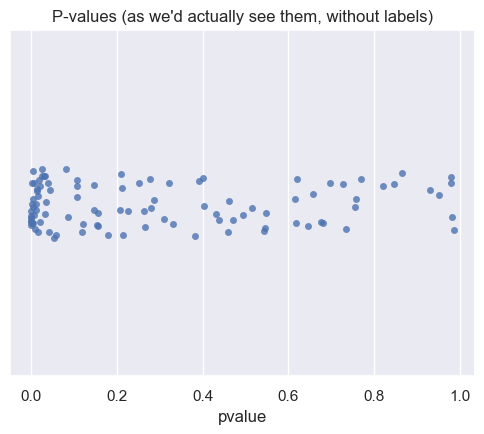

In [8]:
sns.stripplot(
    data=p_values, x='pvalue',
    alpha = 0.8, orient = "h",
)
plt.title("P-values (as we'd actually see them, without labels)");

Normally, we wouldn't know for certain whether or not each change actually affects customer behavior. Instead, we must decide from the p-values. In particular, our job is to decide, based on the p-values, for which tests the data favor the null hypothesis, and for which tests the data favor the alternative hypothesis. From the definition of the p-value, we know that smaller p-values should favor the alternative hypothesis, while larger p-values should favor the null hypothesis.

What if we did magically know the true effect of each change? In this case, we could use that known truth to analyze our decision-making process and evaluate how well we do. 

This is an approach we'll use many times throughout this book: when creating, designing, and evaluating our algorithms, we'll suppose that we know the "true" values of reality, so that we can provide a quantitative analysis. Then, when we go apply those algorithms in the real world (where we don't know reality), we can be confident in how well we're doing.

The column `is_alternative` contains the known true effects for each of these 100 A/B tests:

In [4]:
p_values.head(3)

,pvalue,is_alternative
0,0.040131,0
1,0.000436,1
2,0.251129,0


We can visualize the p-values again, this time grouped by whether or not the website change actually affected customers' purchase behavior (i.e., reality). The top row contains the points where the null is true, and the bottom row contains the points where the alternative is true.

(-0.049319194537530316, 1.035869189459966, 1.5, -0.5)


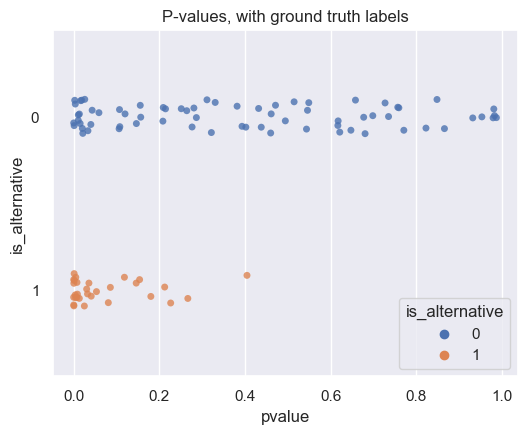

In [56]:
sns.stripplot(
    data=p_values, x='pvalue', y='is_alternative', hue='is_alternative', 
    alpha = 0.8, order = [0, 1], orient = "h",
)
plt.title('P-values, with ground truth labels');
print(plt.axis())

We can now see that any particular threshold we choose will lead us to make some correct and some incorrect decisions. For example, suppose we use a p-value threshold of 0.1:

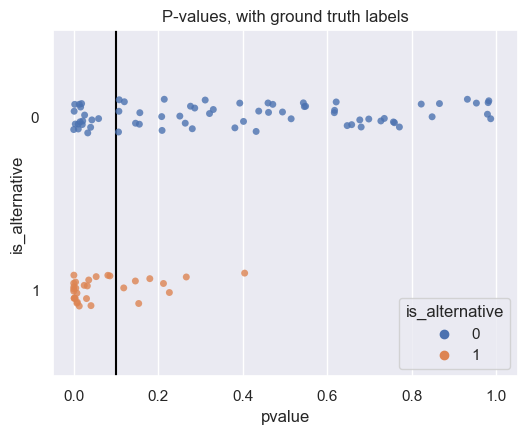

In [57]:
sns.stripplot(
    data=p_values, x='pvalue', y='is_alternative', hue='is_alternative',
    alpha = 0.8, order = [0, 1], orient = "h",
)
plt.vlines(0.1, -0.5, 1.5, color='black')
plt.axis([-0.05, 1.05, 1.5, -0.5])
plt.title('P-values, with ground truth labels');

For p-values smaller than our threshold (to the right of the line), our decision is 1. So:
* For all the orange (bottom) points to the left of the line, we make a correct decision: in this case, reality and our decision are both 1 (alternative), so these are *true positives*. 
* For all the orange (bottom) points to the right of the line, we make an incorrect decision: in this case, reality is 1 (alternative), but our decision is 0 (null). So, these are *false negatives*.
* For all the blue (top) points to the left of the line, we make an incorrect decision: in this case, reality is 0 (null), but our decision is 1 (alternative). So, these are *false positives*.
* For all the blue (top) points to the right of the line, we make a correct decision: in this case, reality and our decision are both 0 (null), so these are *true negatives*. 

Our goal should be to make as many true negatives and true positives as possible, while making as few false positives and false negatives as possible. But we can see from the graph that there is a tradeoff: as we make fewer false positives, we must necessarily make more false negatives. For example, suppose we wanted to have no false negatives at all. That means we want all the p-values from tests where the alternative is true to be below our threshold (all orange points to the left of the line).Let's see what happens if we choose such a threshold of 0.42:

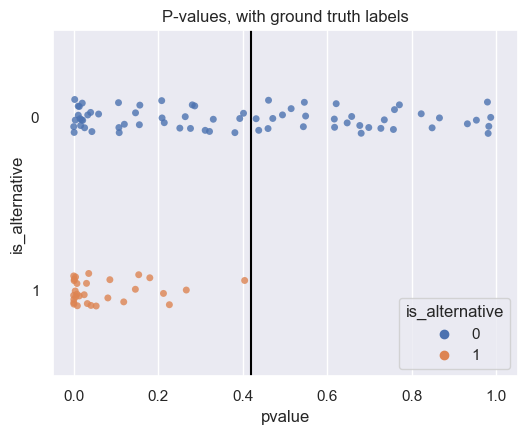

In [58]:
sns.stripplot(
    data=p_values, x='pvalue', y='is_alternative', hue='is_alternative', 
    alpha = 0.8, order = [0, 1], orient = "h",
)
plt.vlines(0.42, -0.5, 1.5, color='black')
plt.axis([-0.05, 1.05, 1.5, -0.5])
plt.title('P-values, with ground truth labels');

Even though we've dropped our false negative rate dramatically, we've unfortunately increased our false positive rate: there are now many more tests where the null is true but the p-value is below our threshold (blue points to the left of the line).

## Simple and Composite Hypotheses

When conducting hypothesis testing, our null and alternative hypotheses fall into one of two categories:

* A **simple** hypothesis is precise, and states that the test statistic takes on a particular value. For example, hypotheses such as "there is no difference between the average values in the two groups ($\mu_1 - \mu_2 = 0$)" or "the true proportion is 0.5 ($q = 0.5$)" provide one single value for the test statistic.

* In contrast, a **composite** hypothesis is less specific, and usually describes the test statistic as being greater than, less than, or not equal to some reference value. For example, hypotheses such as "the average of the first group is greater than the average of the second group ($\mu_1 - \mu_2 > 0$)" or "the true proportion is not equal to 0.5 ($q \neq 0.5$)" are composite.

In most hypothesis tests you've seen so far, you've likely worked with a simple null hypothesis (i.e., one that's specific that we can simulate or calculate under), and a composite alternative hypothesis. Later, we'll explore what happens when we use a simple alternative hypothesis as well.

## From p-values to decisions

We've seen above that in order to make a binary decision from a single p-value, we must use some threshold. We'll see several different ways to choose such a threshold:

* Classical null hypothesis significance testing (NHST): here, we choose a threshold based on our desired false positive rate. For example, the traditional (arbitrary) threshold of 0.05 corresponds to a 5% chance of making a false positive with each hypothesis test we conduct. In this setting, our null hypothesis will usually be a clearly specified simple hypothesis, but we usually use "vague" composite alternative hypotheses such as 'there is no difference between the two groups'. This means that we can precisely analyze what happens when the null is true ($R=0$), and reason about the false positive rate and true negative rate. However, because our alternative hypothesis is composite, we can't precisely define what happens in the alternative case, so we typically don't reason about the true positive rate and false negative rate (i.e., the rates corresponding to $R=1$).
* In the Neyman-Pearson framework, we choose a simple alternative hypothesis, and reason about the true positive rate.
* When making multiple tests, we'll need to choose thresholds that take into account error rates involving all the tests we conduct. We'll examine these error rates and why they're important in the next section.

In [54]:
# NO CODE

# VIDEO: B-H Algorithm Overview and Example
from IPython.display import YouTubeVideo
YouTubeVideo('WIrueFDjw64')

In [78]:
sns.set_theme(style='whitegrid')

def make_null_alternative_plots(
    show_null=True, show_alternative=True, threshold=0.7, fill_alpha=0.3
):
    null_color = 'tab:red'
    alternative_color = 'tab:blue'
    null_mean = 0
    alt_mean = 2.5
    sigma = 1
    bounds = [-2, 5, -0.02, 0.42]
    null_right = 'red'
    null_left = 'gold'
    alternative_right = 'green'
    alternative_left = 'purple'

    f, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
    t = np.linspace(bounds[0], bounds[1], 1000)
    zero = np.zeros_like(t)
    null = stats.norm(null_mean, sigma).pdf(t)
    alternative = stats.norm(alt_mean, sigma).pdf(t)

    if show_null:
        ax.plot(t, null, lw=2, color=null_color, label='Null distr.')
        ax.fill_between(t, zero, null, t > threshold, color=null_right, alpha=fill_alpha)
        ax.fill_between(t, zero, null, t < threshold, color=null_left, alpha=fill_alpha)
            
    if show_alternative:
        ax.plot(t, alternative, lw=2, color=alternative_color, label='Alt distr.')
        ax.fill_between(t, zero, alternative, t > threshold, color=alternative_right, alpha=fill_alpha)
        ax.fill_between(t, zero, alternative, t < threshold, color=alternative_left, alpha=fill_alpha)
    
    ax.axvline(threshold, color='black', lw=2)
    ax.axis(bounds)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$p(t)$')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Trading off between different row-wise rates

Analysis of $p$-values helps us understand what happens if the null is true: we saw earlier that the $p$-value threshold we choose is the false positive rate for the test. But what about if the alternative is true? For example, we may be interested in constructing a test where we want the false negative rate to be less than $0.1$, or we may want to numerically quantify how much the false negative rate would increase if we reduced our false positive rate by $0.01$. 

Composite alternative hypotheses don't support the kind of analysis we did above: we can only reason about the alternative case if we choose a simple alternative hypothesis. So, for the remainder of this section, we'll only consider the case where **both the null and alternative hypotheses are simple**.

There are many ways to analyze the tradeoff, so we'll focus on two of them:

1. **How do we quantify the tradeoff between false positive rate and false negative rate?** In other words, how do we measure the tradeoff between the row-wise rates for $R=0$ and the row-wise rates for $R=1$? We'll use a receiver operating characteristic curve, commonly known as an **ROC curve**, to answer this. For more, see the binary classification section.

2. **For a given false positive rate (i.e., significance threshold or $p$-value threshold), what test statistic should we choose to maximize the power, or true positive rate?** In other words, if we fix a desired level of error for the case where $R=0$, how do we get the best possible performance when $R=1$? This is what we'll turn our attention to now.

### Understanding the power-significance tradeoff in hypothesis testing

When using the Neyman-Pearson lemma, our goal will be to find the most powerful test for any given level of significance. In other words, for any desired FPR we specify (i.e., we want to control our error probability if the null is true), we want to find the test with the highest possible power (i.e., we want to maximize our success probability if the alternative is true). 

We'll do so by choosing a test statistic (i.e., a function of our observed data) that maximizes the power. Instead of computing a $p$-value as before, we'll make a decision by applying a threshold to our test statistic: if it's above our threshold, then we'll reject the null, and if it's below our threshold, we'll fail to reject the null.

Before we see what this test statistic is, let's look at a few diagrams that help illustrate the trade-off between power and significance. Suppose we observe a single normally distributed data point $x$, and our test statistic is $t=x$. We'll assume that $t \sim \mathcal{N}(\mu, 1)$, for some mean $\mu$. If our null hypothesis states that $\mu = 0$, then we can write $t | H_0 \sim \mathcal{N}(0, 1)$. Therefore, our distribution for $t$ under the null hypothesis is:

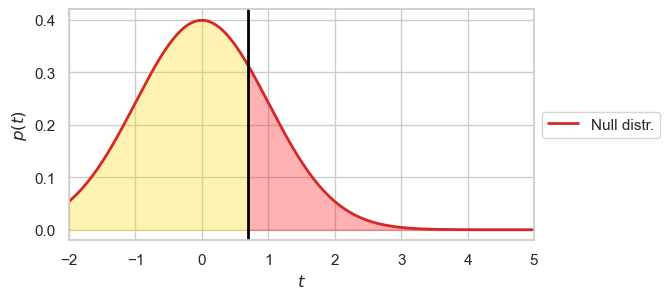

In [79]:
make_null_alternative_plots(show_null=True, show_alternative=False)

The black vertical line shows one arbitrarily chosen decision threshold: if we use this threshold, the shaded areas show the FPR (right, red) and TNR (left, yellow) of our test. We can see that if we were to raise the threshold, we'd obtain a lower false positive rate (red).

But what about the power? If we want to follow a similar process to compute the power (or TPR) of the test, we must use a simple alternative hypothesis. A compound alternative such as $\mu > 0$ won't give us enough information to compute the error rates under the alternative. So, we'll choose a specific alternative hypothesis: $T | H_1 \sim \mathcal{N}(2.5, 1)$:

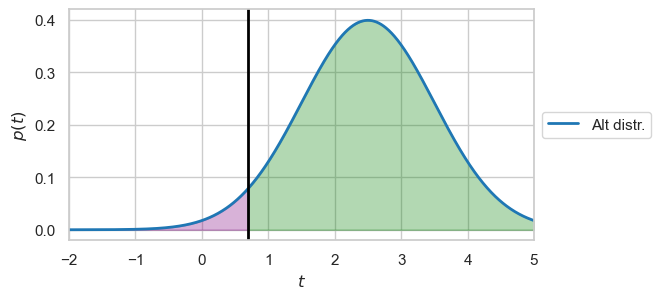

In [80]:
make_null_alternative_plots(show_null=False, show_alternative=True)

For this choice of the alternative hypothesis, we can now see the power (TPR) and FNR as the green (right) and purple (left) areas, respectively. If we were to raise the threshold, we'd obtain a lower power (green).

Now, we'll visualize both hypotheses on the same graph:

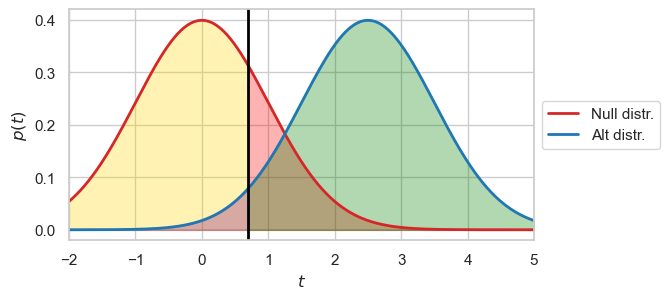

In [81]:
make_null_alternative_plots(show_null=True, show_alternative=True)

Now, we can see the impact of our threshold in both cases: if the null is true, our error probability is the area under the red curve to the **right** of the threshold (make sure you convince yourself why this is true). If the alternative is true, our error probability is the area under the blue curve to the **left** of the threshold. Ideally, we want both of these areas to be as small as possible, but in practice, we often must trade off one for the other.

The Neyman-Pearson lemma helps us quantify this tradeoff by choosing a good test statistic. Recall our testing framework: we first specify the distribution of the data under the null and the alternative (e.g., above, we chose $X | H_0 \sim \mathcal{N}(0, 1)$ and $X | H_1 \sim \mathcal{N}(2.5, 1)$). Then, we choose a test statistic that helps us distinguish between the null and the alternative. In the very simple example above, where we only observed one data point, we just chose our test statistic to be the data point we observed. But in general, when we observe many data points and have to choose between more complex hypotheses, there are many possible test statistics we could choose. 

Note that above, we defined a distribution for our data given each hypothesis: these are called **likelihood functions**. They specify the distribution for our observed data given a certain unknown state of the world. In the conventional hypothesis testing setup, we only need to define the likelihood under the null (or be able to simulate it). When we want to reason about power, we need to specify the likelihood under the alternative as well. This usually requires us to make a specific assumption about the size of the difference or effect that we are looking for: any calculation of power is based on this assumption.

### Neyman-Pearson

The Neyman Pearson lemma states that for any desired level of significance (i.e., false positive rate) that we wish to achieve, we can achieve the highest possible power by computing the **likelihood ratio** as our test statistic, and then comparing it to a threshold that's determined by our desired significance. 

Given observed data $x$ (which can often represent multiple observations), and likelihood functions for the null and alternative, we compute the test statistic:

$$
LR = \frac{p(x|H_1)}{p(x|H_0)}
$$

and compare it to some threshold $\eta$. If the likelihood ratio is greater than the threshold, we reject the null, and if it's below the threshold, we fail to reject. Intuitively, this test asks: "how many times more likely are the data under the alternative, compared to under the null?" Our threshold then determines how much more likely we require the data to be under the alternative before we decide to reject the null. For example, a threshold of 2 requires us to see data that are twice as likely under the alternative (relative to the null) before we decide to reject the null.

Using the Neyman-Pearson lemma in practice typically involves the following sequence of steps:

1. Define the likelihood functions for the observed data according to the null and alternative hypothesis.
2. Identify a desired level of significance (i.e., false positive rate that you are willing to tolerate).
3. Use the significance level to compute a threshold by (a) expressing the false positive rate as a conditional probability based on the decision rule described above, (b) setting it equal to the desired significance level, and (c) solving for the threshold as a function of the significance level.
4. Compute the power of the test by (a) expressing the power as a conditional probability based on the decision rule above and (b) plugging in the threshold computed in the previous step.

By solving for the threshold in step (3) in terms of any desired significance level, we can use step (4) to explicitly relate the tradeoff between power and significance level.